In [1]:
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import numpy as np
import matplotlib.pyplot as plt

## System checkup

In [2]:
# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 5231
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

# Set GPU memory growth 
# Allows to only as much GPU memory as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Data preparation

In [3]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(validation_split=0.1,
                                        rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(validation_split=0.1,
                                        rescale=1./255)

In [4]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'Classification_Dataset')

# Batch size
bs = 32

# img shape
img_h = 256
img_w = 256

num_classes=20

decide_class_indices = True
if decide_class_indices:
    classes = ['owl',               #0
               'galaxy',            #1
               'lightning',         #2
               'wine-bottle',       #3
               't-shirt',           #4
               'waterfall',         #5
               'sword',             #6
               'school-bus',        #7
               'calculator',        #8
               'sheet-music',       #9
               'airplanes',         #10
               'lightbulb',         #11
               'skyscraper',        #12
               'mountain-bike',     #13
               'fireworks',         #14
               'computer-monitor',  #15
               'bear',              #16
               'grand-piano',       #17
               'kangaroo',          #18
               'laptop']            #19
else:
    classes=None


training_dir = os.path.join(dataset_dir, 'training')

# Training
print("Training data: ")
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=bs,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED)  # targets are directly converted into one-hot vector

# Validation
print("Validation data: ")
valid_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=bs,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation',
                                               seed=SEED)  # targets are directly converted into one-hot vector

Training data: 
Found 1406 images belonging to 20 classes.
Validation data: 
Found 148 images belonging to 20 classes.


In [5]:
# Create Dataset objects
# ----------------------

# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

train_dataset = train_dataset.repeat()

# Validation
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

test_dataset = valid_dataset.repeat()

## Convolutional Neural Network (CNN)

In [6]:
# CNN layers
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(img_w, img_h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# FC layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        1

In [7]:
# Optimization params
# -------------------
epoch_num = 30
lr = 1e-3

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# Optimazer
optimizer = tf.keras.optimizers.Adam()
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=train_dataset,
                    epochs=epoch_num,
                    steps_per_epoch=len(train_gen),
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen))

Train for 44 steps, validate for 5 steps
Epoch 1/30
44/44 [==============================] - 19s 440ms/step - loss: 2.9849 - accuracy: 0.0533 - val_loss: 2.9314 - val_accuracy: 0.0811
Epoch 2/30
44/44 [==============================] - 17s 388ms/step - loss: 2.9110 - accuracy: 0.0910 - val_loss: 2.8866 - val_accuracy: 0.1216
Epoch 3/30
44/44 [==============================] - 17s 387ms/step - loss: 2.7527 - accuracy: 0.1351 - val_loss: 2.6752 - val_accuracy: 0.1284
Epoch 4/30
44/44 [==============================] - 17s 391ms/step - loss: 2.5987 - accuracy: 0.1714 - val_loss: 2.5068 - val_accuracy: 0.2095
Epoch 5/30
44/44 [==============================] - 17s 388ms/step - loss: 2.4382 - accuracy: 0.2432 - val_loss: 2.4169 - val_accuracy: 0.2770
Epoch 6/30
44/44 [==============================] - 17s 395ms/step - loss: 2.2674 - accuracy: 0.3030 - val_loss: 2.3919 - val_accuracy: 0.2365
Epoch 7/30
44/44 [==============================] - 18s 400ms/step - loss: 2.2361 - accuracy: 0.2866 

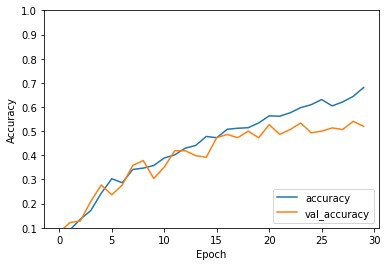

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [9]:
from datetime import datetime

def create_csv(results, results_dir='./Test_Result'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [10]:
import PIL
from PIL import Image
# ....

test_dir = os.path.join(dataset_dir, 'test')
image_filenames = next(os.walk(test_dir))[2]

results = {}
for image_name in image_filenames:

   img = Image.open(os.path.join(test_dir, image_name)).convert('RGB')
   img = img.resize((img_w, img_h), PIL.Image.ANTIALIAS)
   img_array = np.array(img)
   img_array = np.expand_dims(img_array, 0) 
                                 
   img_array = img_array/255.0
   prediction = model.predict(img_array)   # predicted class

   results[image_name] = np.argmax(prediction)

create_csv(results)